In [1]:
### imports ###
import pygmt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
from mpl_toolkits.basemap import Basemap

import pandas as pd

%matplotlib inline
%matplotlib widget


# time series plot
import xarray as xr
xr.set_options(keep_attrs=True)

import datetime

import os
dir = "/Users/rochelle/Documents/GitHub/Leeds-Research-Internship/"
os.chdir(dir)


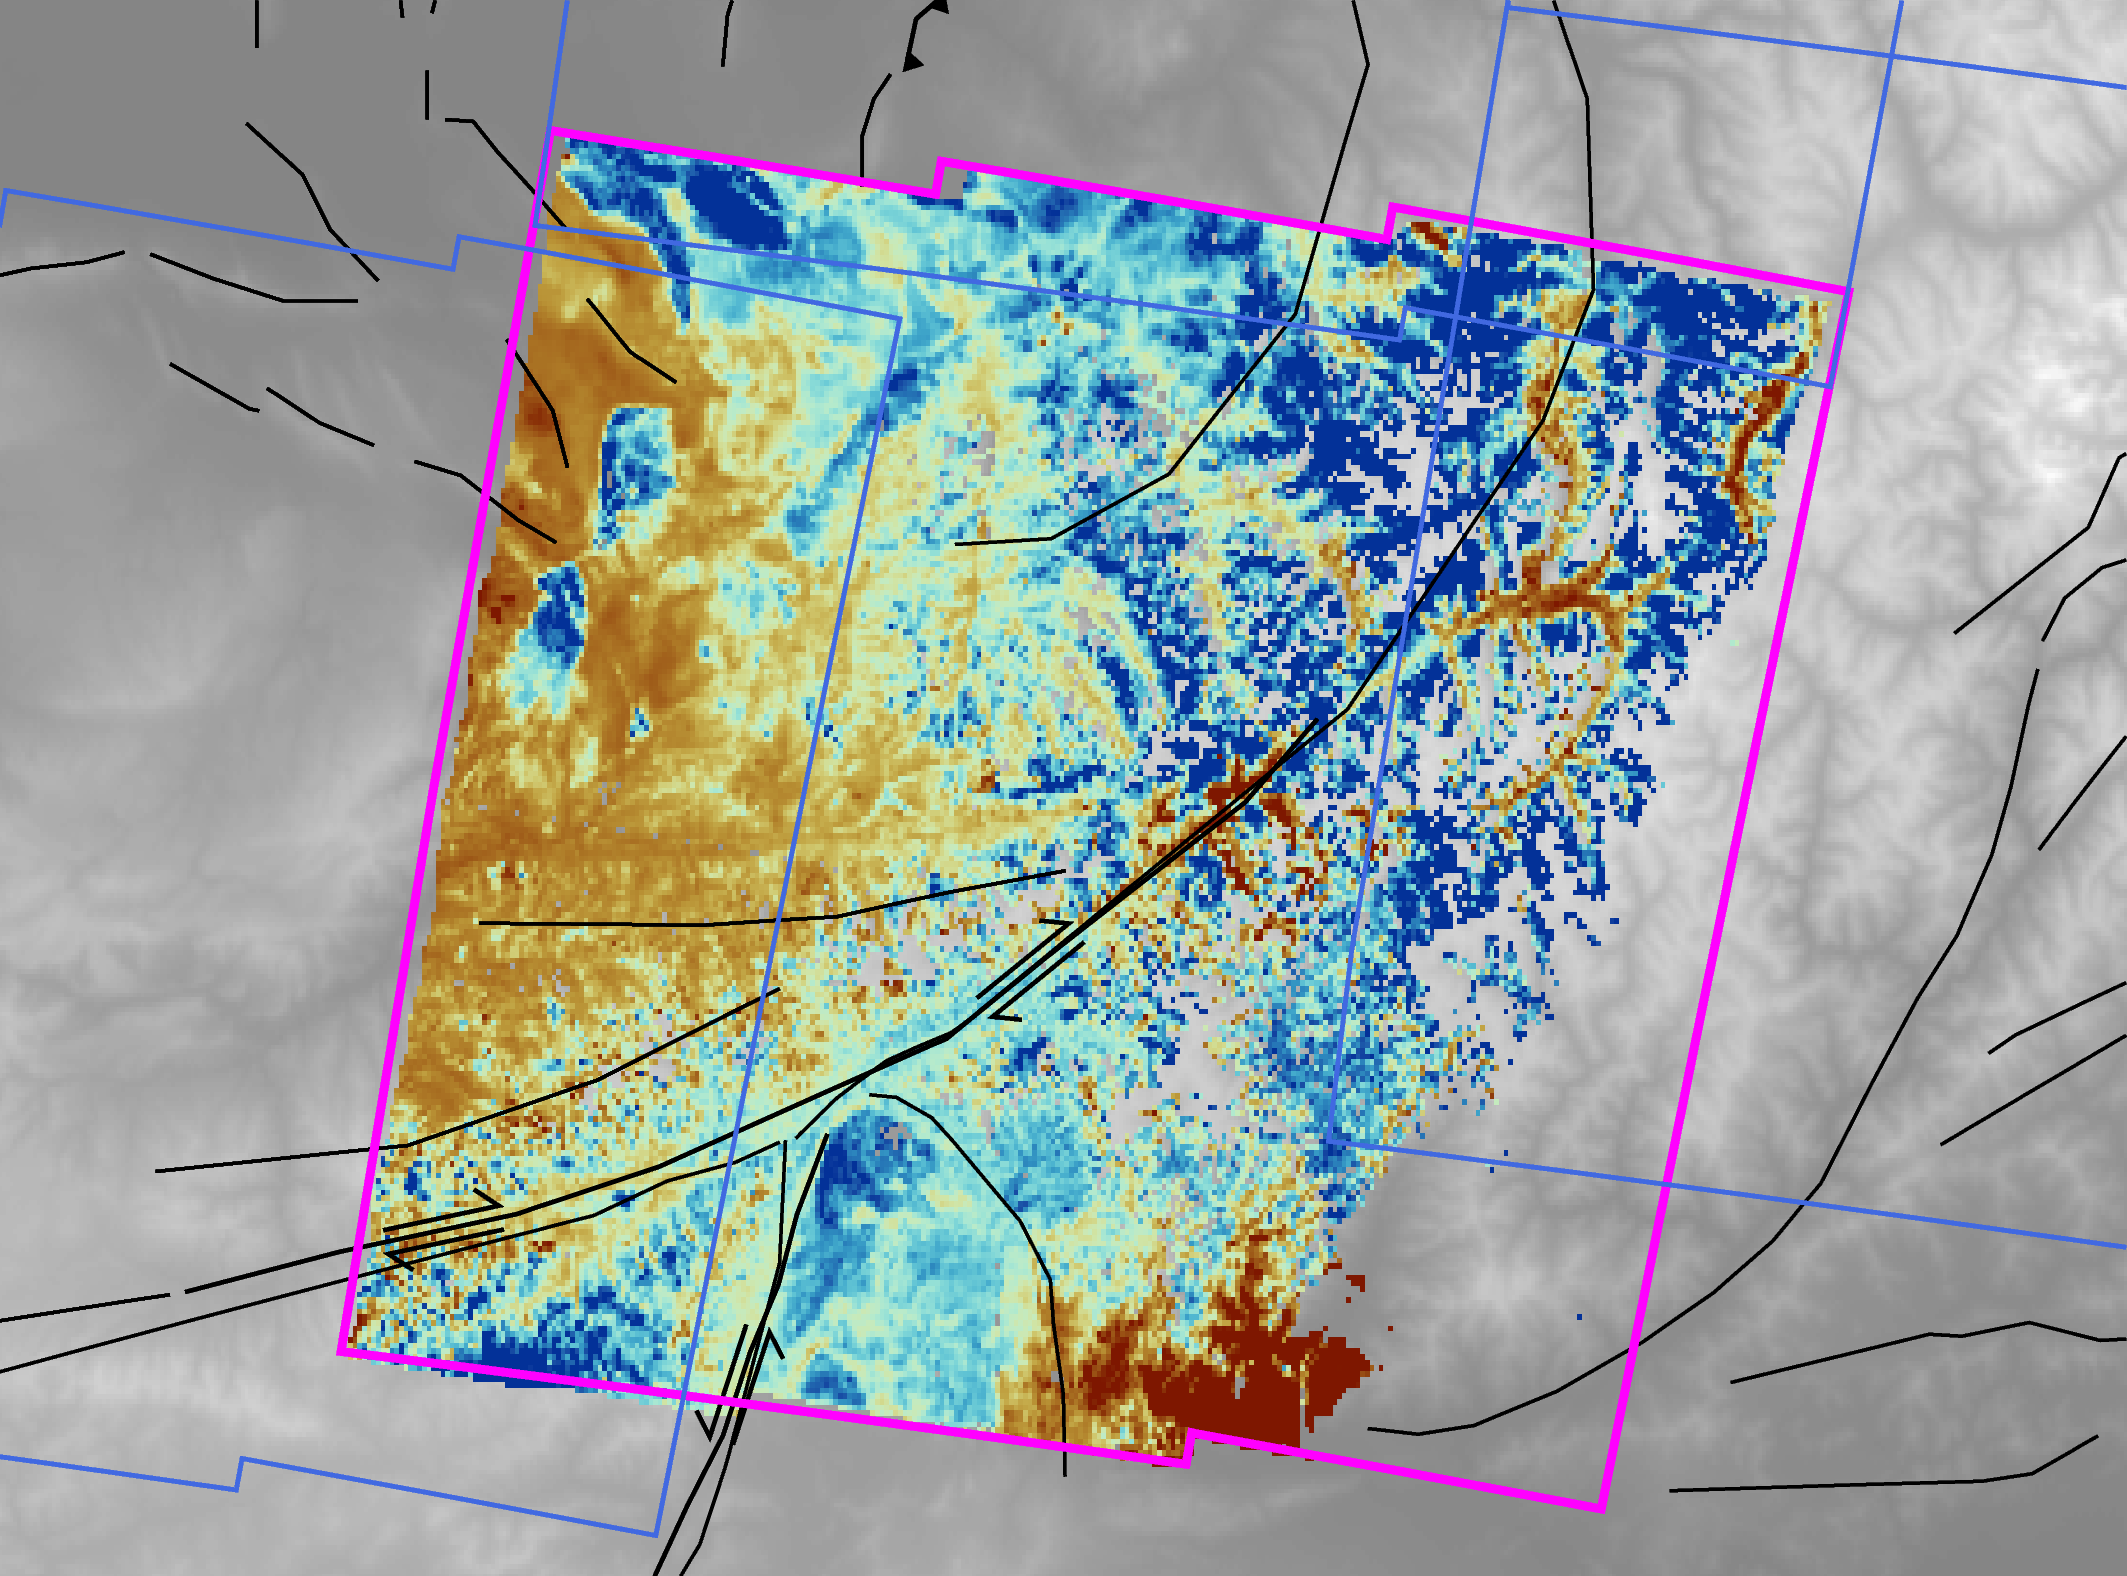

In [2]:
###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=67.4 # lower left corner longitude 
llcrnrlat=34.3 # lower left corner latitude
urcrnrlon=72 # upper right corner longitude
urcrnrlat=37.08 # upper right corner latitude


proj_scale_w = 18 # specify projection scale (width)
proj_scale_unit = "c" # choose between c (cm) and i (inches)
# 17.78c = 7i


InSAR_NetCDF = "078D_05435_131313_run5.nc"
frame = "078D_05435_131313"

mindate = datetime.date(2016,3,9)
maxdate = datetime.date(2024,7,10)

lon = 70
lat = 36
###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]



fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain") # figure config (borders)
fig.coast(region=region,\
          projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w, proj_scale_unit),\
          water="white", land="grey", shorelines="1/0.5p")

          # Mercator
          # a2f0.5 --> major ticks every 2 and minor ticks every 0.5

grid = pygmt.datasets.load_earth_relief("30s", registration="gridline", region=region)

fig.grdimage(grid=grid, cmap="bin/cpt/custom/seabluelandgrey.cpt")

## plotting vel TEST
pygmt.makecpt(output="bin/cpt/roma_InSAR", series=[-10, 10], reverse=True, cmap="bin/cpt/GMT_supported/roma.cpt")
              # redefine scale + inverse
              # stored in local sesh

ncarray = xr.open_dataset("bin/" + InSAR_NetCDF)
vel = ncarray["vel"]
mskd = ncarray["mask"]
vel_mskd = vel * mskd
vel_mskd = vel_mskd.where(vel_mskd != 0, np.nan)

fig.grdimage(grid=vel_mskd, nan_transparent = True, transparency = 0, cmap="bin/cpt/roma_InSAR")



## plotting faults
# https://www.pygmt.org/dev/gallery/lines/linefronts.html
fig.plot(data="bin/faults/HimaTibetMap.gmt", pen=f"0.7p,black") # all faults
fig.plot(data="bin/faults/gem_active_faults.gmt", pen=f"0.7p,black") # gem
fig.plot(data="bin/faults/normal.gmt", style="f1c/0.13c+l+b", pen=f"0.95p,black", fill="black") # normal
fig.plot(data="bin/faults/thrust.gmt", style="f1c/0.13c+l+t", pen=f"0.95p,black", fill="black") # thrust
fig.plot(data="bin/faults/dextral.gmt", style="f5c/1c+r+s45+o2.25c", pen=f"0.95p,black", fill="black") # dextral (right)
fig.plot(data="bin/faults/sinistral.gmt", style="f5c/1c+l+s45+o2.25c", pen=f"0.95p,black", fill="black") # sinistral (left)


## plotting poly.txt

### Descending ###
fig.plot(data="bin/metadata/descending/078D_05435_131313-poly.txt", pen=f"2p,magenta") # 078D_05435_131313
fig.plot(data="bin/metadata/descending/005D_05398_131313-poly.txt", pen=f"1p,royalblue") # 005D_05398_131313
fig.plot(data="bin/metadata/descending/151D_05440_131313-poly.txt", pen=f"1p,royalblue") # 151D_05440_131313
fig.plot(data="bin/metadata/descending/078D_05237_131313-poly.txt", pen=f"1p,royalblue") # 078D_05237_131313
fig.plot(data="bin/metadata/descending/005D_05199_131313-poly.txt", pen=f"1p,royalblue") # 005D_05199_131313
fig.plot(data="bin/metadata/descending/107D_05290_121313-poly.txt", pen=f"1p,royalblue") # 107D_05290_121313
fig.plot(data="bin/metadata/descending/107D_05092_141313-poly.txt", pen=f"1p,royalblue") # 107D_05092_141313-poly.txt

fig.show()
fig.savefig("figures/078D_05435_131313_run5.png")

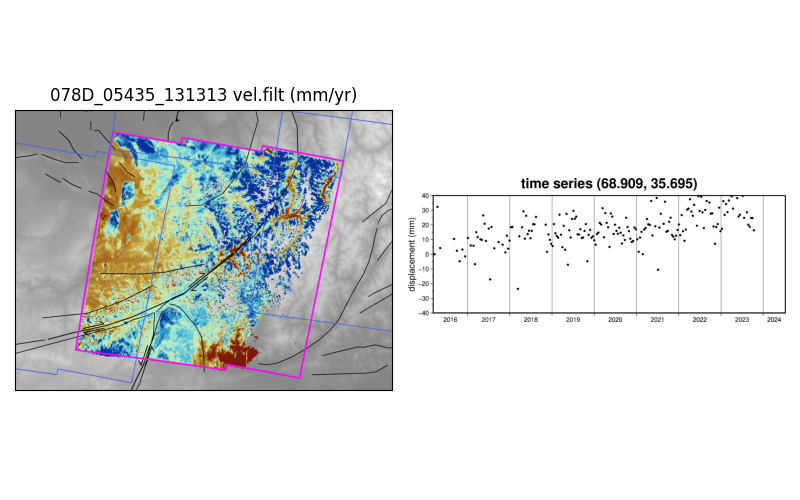

In [3]:
png_path = "figures/078D_05435_131313_run5.png"
spam_path = "figures/time_series_spam.png"

img = Image.open(png_path)
width, height = img.size # (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

assert DPI_horz == DPI_vert

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(121)

# creating matplotlib basemap for overlay
m = Basemap(projection='merc', resolution='i',\
                        llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,\
                        llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon)

m.drawcoastlines() # draws coastlines on matplotlib. this makes sure that everything is aligned
'''
# plotting parallels and meridians, annotating axis
grid_freq = 1
parallels = np.arange(-90, 90, grid_freq)
meridians = np.arange(-180, 180, grid_freq)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=12, linewidth=0.5) # label parallels on right and top
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=12, linewidth=0.5) # meridians on bottom and left
'''

img = mpimg.imread(png_path)
m.imshow(img, origin='upper')

ax1.set_title(frame+" vel.filt (mm/yr)")


ax2 = fig.add_subplot(122)
ax2.axis('off')
plt.tight_layout()

img = Image.open(spam_path)
width, height = img.size # (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

img = mpimg.imread(spam_path)
ax2.imshow(img, origin='upper')


def pos_to_lonlat(x, y):
  lon, lat = m(x, y, inverse=True)
  return lon, lat

pos = [] # in format [[None, None], [x, y], [x, y], ...]
lonlat = []

ds = xr.open_dataset("bin/"+InSAR_NetCDF)
time_ds=ds["time"].values
time = pd.to_datetime(time_ds)

cum=ds["cum"]

def onclick(event):
  pos.append([event.xdata, event.ydata])

  lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1]) # pos[-1] represents last click (list with x, y)
  lonlat.append([lon, lat]) # converts x y to lon lat and appends

  # ax1.set_title(f'Click {len(pos)}: {lon}, {lat}') 
  cum_point = cum.sel(lon=lon, lat=lat, method='nearest')

  fig = pygmt.Figure()

  fig.plot(
      projection="X18c/6c",
      region=[mindate, maxdate, -40, 40],
      frame=["+t time series (%.3f, %.3f)" % (lon, lat),\
              "xa1Yfg1Y", "ya10f5+ldisplacement (mm)"],
      x=time,
      y=cum_point,
      style="c0.1c",
      fill="black",
      pen="thinnest"
  )

  fig.basemap(frame=True)
  fig.savefig(spam_path)

  img = mpimg.imread(spam_path)
  ax2.imshow(img, origin='upper')





cid=fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:


'''


ds = xr.open_dataset("bin/"+InSAR_NetCDF)
time_ds=ds["time"].values
time = pd.to_datetime(time_ds)

cum=ds["cum"]
cum_point = cum.sel(lon=lon, lat=lat, method='nearest')

range_max = max_cum_value = ds['cum'].max().item()

fig = pygmt.Figure()

fig.plot(
    projection="X18c/6c",
    region=[mindate, maxdate, -40, 40],
    frame=["+t "+ frame + "   (%.3f, %.3f)" % (lon, lat),\
            "xa1Yfg1Y", "ya10f5+ldisplacement (mm)"],
    x=time,
    y=cum_point,
    style="c0.1c",
    fill="black",
    pen="thinnest"
)

fig.basemap(frame=True)

fig.show()
fig.savefig("figures/time_series_test.png")
'''

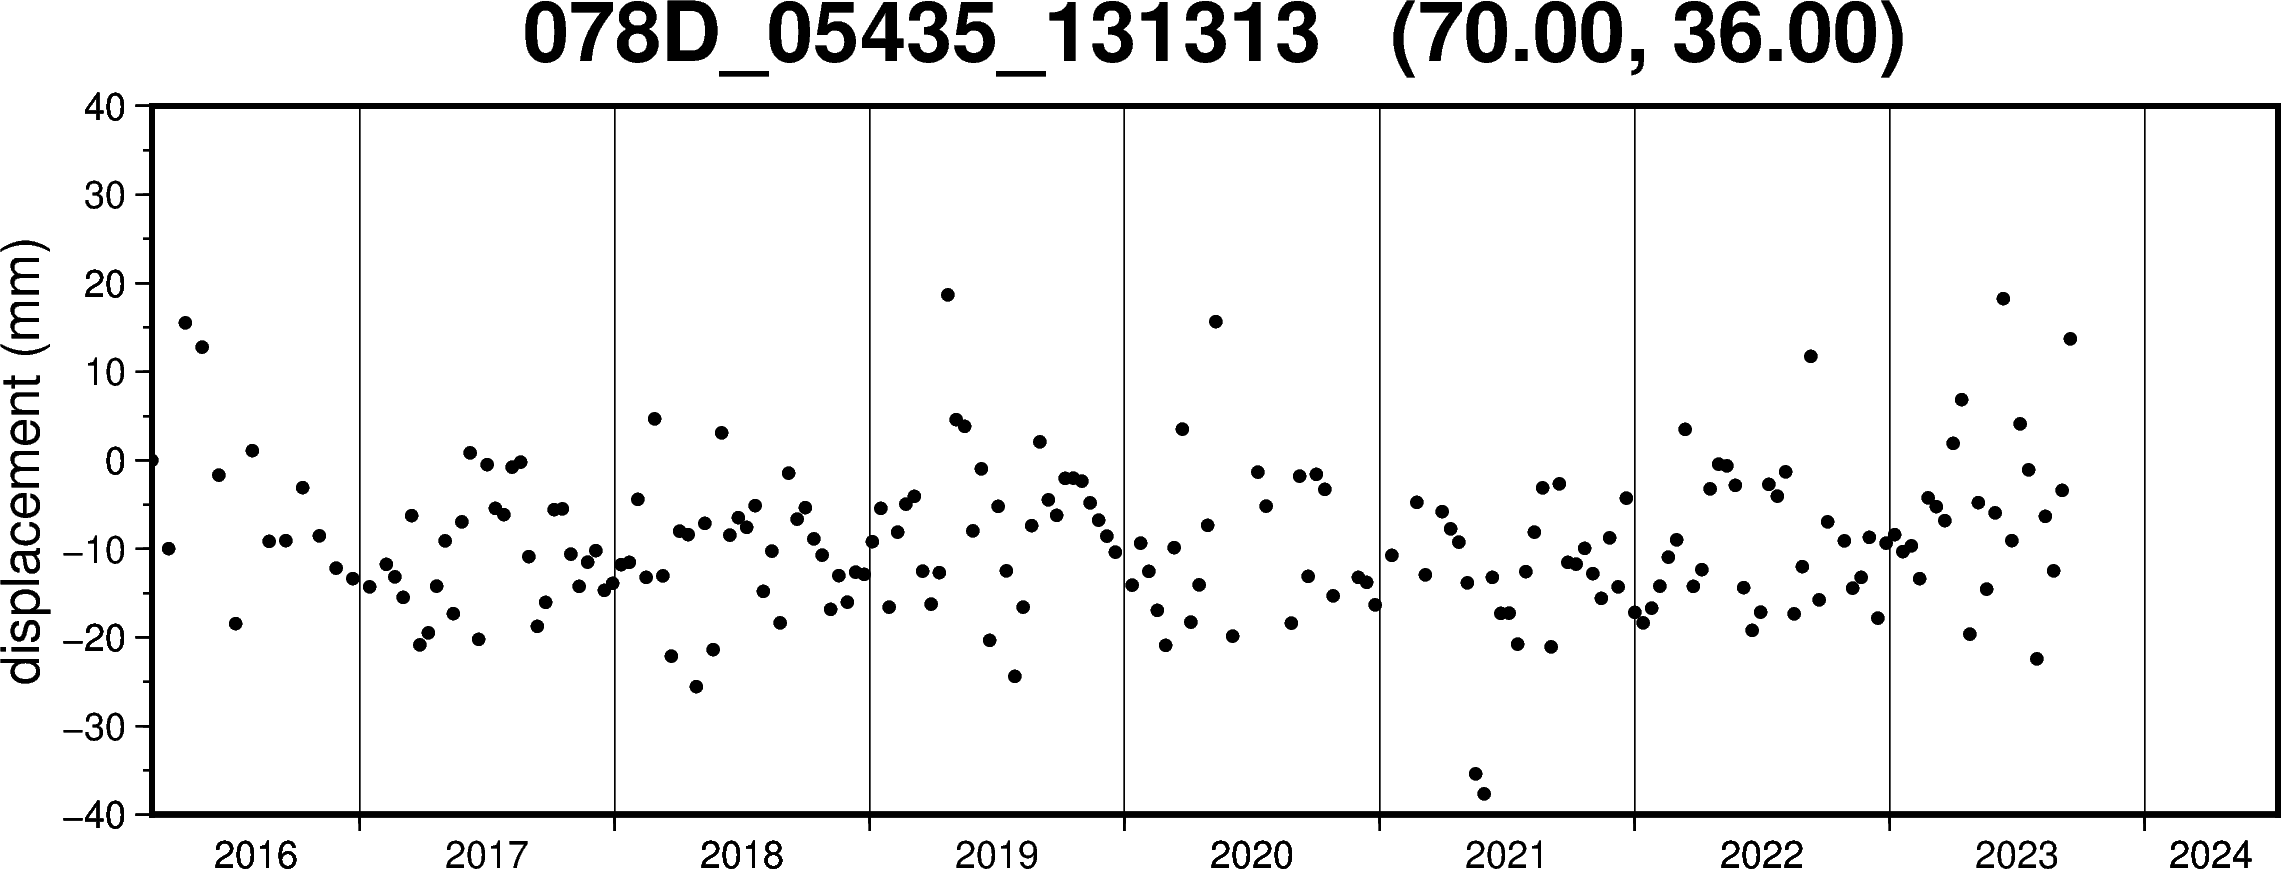

In [53]:
# time series plot
import xarray as xr
xr.set_options(keep_attrs=True)

import datetime

###########################################
InSAR_NetCDF = "071A_05440_131313_test_reunwrapping.nc"
frame = "078D_05435_131313"

metadata = "bin/metadata/descending/078D_05435_131313_metadata.txt"
mindate = datetime.date(2016,3,9)
maxdate = datetime.date(2024,7,10)

lon = 70
lat = 36
###########################################
ds = xr.open_dataset("bin/"+InSAR_NetCDF)
time_ds=ds["time"].values
time = pd.to_datetime(time_ds)

cum=ds["cum"]
cum_point = cum.sel(lon=lon, lat=lat, method='nearest')

range_max = max_cum_value = ds['cum'].max().item()

fig = pygmt.Figure()

fig.plot(
    projection="X18c/6c",
    region=[mindate, maxdate, -40, 40],
    frame=["+t "+ frame + "   (%.3f, %.3f)" % (lon, lat),\
            "xa1Yfg1Y", "ya10f5+ldisplacement (mm)"],
    x=time,
    y=cum_point,
    style="c0.1c",
    fill="black",
    pen="thinnest"
)

fig.basemap(frame=True)

fig.show()
fig.savefig("figures/time_series_test.png")
'''

In [48]:
# time series plot
import xarray as xr
xr.set_options(keep_attrs=True)

import datetime
from datetime import datetime, date

###########################################
InSAR_NetCDF = "071A_05440_131313_test_reunwrapping.nc"
frame = "078D_05435_131313"

metadata = "bin/metadata/descending/078D_05435_131313_metadata.txt"
mindate = 2016,3,9
maxdate = 2024,7,10

lon = 70
lat = 36
###########################################

ds = xr.open_dataset("bin/"+InSAR_NetCDF)
time_ds=ds["time"].values
time = pd.to_datetime(time_ds)

cum=ds["cum"]
cum_point = cum.sel(lon=lon, lat=lat, method='nearest')

print(cum_point)
max_cum_value = ds['cum'].max().item()
print(max_cum_value)
'''
time_arr = time_ds.astype('datetime64[ns]').astype(datetime)
time_list = [dt.date() for dt in time_arr]

print(time_list)
    
cum=ds["cum"]

cum_point = cum.sel(lon=lon, lat=lat, method='nearest')

print(time)
print(cum)
print(cum_point)
'''

<xarray.DataArray 'cum' (time: 203)> Size: 812B
[203 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2016-03-09 2016-04-02 ... 2023-09-17
    lat      float64 8B 36.0
    lon      float64 8B 70.0
Attributes:
    grid_mapping:  spatial_ref
463.0265197753906


'\ntime_arr = time_ds.astype(\'datetime64[ns]\').astype(datetime)\ntime_list = [dt.date() for dt in time_arr]\n\nprint(time_list)\n    \ncum=ds["cum"]\n\ncum_point = cum.sel(lon=lon, lat=lat, method=\'nearest\')\n\nprint(time)\nprint(cum)\nprint(cum_point)\n'

In [13]:
###########################################
InSAR_NetCDF = "078D_05435_131313_Milan.nc"
frame = "078D_05435_131313"

metadata = "bin/metadata/descending/078D_05435_131313_metadata.txt"
mindate = 2016,3,9
maxdate = 2024,7,10

lon = 70
lat = 36
###########################################
ds = xr.open_dataset("bin/"+InSAR_NetCDF)
time = ds["time"]
print(time)

<xarray.DataArray 'time' (time: 210)> Size: 2kB
array(['2016-03-22T00:00:00.000000000', '2016-04-15T00:00:00.000000000',
       '2016-05-09T00:00:00.000000000', ..., '2024-05-03T00:00:00.000000000',
       '2024-05-15T00:00:00.000000000', '2024-05-27T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2016-03-22 2016-04-15 ... 2024-05-27


In [ ]:
import xarray as xr
xr.set_options(keep_attrs=True)

def pygmt_plot(grid, title, label='deformation rate (mm/year)', lims=[-25, 10],
               cmap="roma", photobg=False, plotvec=None):
    ''' Function to generate (nice) plot of given grid using pyGMT
    
    Args:
        grid (xr.DataArray): input grid to plot
        title (str):  title (note too long title will disbalance the figure)
        label (str):  label below the colour scale
        lims (list):  colour scale limits
        cmap (str):   colour scale map (try 'vik' for E-W)
        photobg (bool): will plot orthophotomap as the background (if False, DEM relief is used)
        plotvec (geopandas etc): will plot vector data to the map, using pyGMT defaults
    
    Returns:
        pygmt.figure.Figure
    '''
    try:
        grid = grid.load()
    except:
        print('error loading the input dataarray to memory')
        return False
    # try cmap 'vik' for E-W
    #
    # grid = a['U'].where(a.mask < 5) - 10
    # topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)
    topo_data = '@earth_relief_01s'  # 3 arc second global relief (SRTM3S)

    minlon, maxlon = float(np.min(grid.lon)), float(np.max(grid.lon))
    minlat, maxlat = float(np.min(grid.lat)), float(np.max(grid.lat))

    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.xx", MAP_FRAME_TYPE="plain")
    projection = "M13c" # 'R13c' for Robinson etc.
    region = [minlon, maxlon, minlat, maxlat]
    fig.basemap(region=region, projection=projection, frame=["a0.5f0.25", '+t"{0}"'.format(title)])

    if photobg:
        import contextily as ctx
        sourcetiles = ctx.providers.Esri.WorldImagery
        fig.tilemap(
            region=region, projection=projection,
            # region=[-157.84, -157.8, 21.255, 21.285],
            # projection="M12c",
            # Set level of details (0-22)
            # Higher levels mean a zoom level closer to the Earth's
            # surface with more tiles covering a smaller
            # geographic area and thus more details and vice versa
            # Please note, not all zoom levels are always available
            zoom=14,
            # Use tiles from OpenStreetMap tile server
            source=sourcetiles
        )
        pygmt.makecpt(cmap=cmap, series=lims, background=True)
        fig.grdview(grid=grid, cmap=True, projection=projection, surftype='c', transparency=40)
    else:
        pygmt.makecpt(cmap="gray", series=[-8000, 8000, 1000], continuous=True)
        fig.grdimage(
            grid=topo_data,
            cmap=True,
            region=[minlon, maxlon, minlat, maxlat],
            projection=projection,
            shading=True,
            frame=True
        )
        pygmt.makecpt(cmap=cmap, series=lims, background=True)
        fig.grdimage(grid=grid, cmap=True, projection=projection, frame=True, transparency=40)
    
    fig.coast(shorelines=True, projection=projection)
    if type(plotvec) != type(None):
        fig.plot(plotvec, projection=projection, region=region)
    fig.colorbar(frame='a2f1+l"{}"'.format(label))
    # fig.show()
    return fig

InSAR_NetCDF = "078D_05435_131313_Milan.nc"
a=xr.open_dataset("bin/"+InSAR_NetCDF); vel=a["vel"]; pygmt_plot(vel, title="vel", lims=[-4,4])

In [54]:
import os
dir = "/Users/rochelle/Documents/GitHub/Leeds-Research-Internship/"
os.chdir(dir)

###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=66.8 # lower left corner longitude 
llcrnrlat=34 # lower left corner latitude
urcrnrlon=72.6 # upper right corner longitude
urcrnrlat=37.6 # upper right corner latitude


proj_scale_w = 18 # specify projection scale (width)
proj_scale_unit = "c" # choose between c (cm) and i (inches)
# 17.78c = 7i

meca_trans = 22 # meca transparency
meca_scale = "0.4c" # meca scale

frame = "078D_05435_131313"
# InSAR_tif ="071A_05440_131313_2.vel.filt.mskd.geo.tif"
InSAR_NetCDF = "078D_05435_131313_Milan.nc"
###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]

def plot_vel_esd_gmt(selected_frame_esds, frameta, mindate, maxdate, level1, level2=None, showitrf=True):
    frame = frameta['frame'].values[0]
    #
    fig = pygmt.Figure()
    #
    fig.basemap(
        projection="X18c/6c",
        region=[mindate, maxdate, -300, 300], #datetime.date(2010, 1, 1), datetime.date(2020, 6, 1), 0, 10],
        #frame=["WSen", "af"],
        #frame=["WSne", "xaf", "yaf+l'daz [mm]'"]
        frame=["+t "+frame, "xa1Yfg1Y", "yafg100+ldaz [mm]"]
    )
    #
    if level2:
        fig = figpart_var(level1, selected_frame_esds, frameta, fig, additrf = (True & showitrf), plotstd = False)
        fig = figpart_var(level2, selected_frame_esds, frameta, fig, additrf = (False & showitrf), plotstd = True)
    else:
        fig = figpart_var(level1, selected_frame_esds, frameta, fig, additrf = (True & showitrf), plotstd = True)
    #
    #print('legend')
    fig.basemap(frame=True) #["WSen", "af"])
    fig.legend(position="JBL+jBL+o0.1c", box='+gwhite+p1p')
    #fig.show(dpi=120)
    return fig
